In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alamshihab075/mental-health-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mental-health-dataset' dataset.
Path to dataset files: /kaggle/input/mental-health-dataset


In [3]:
df = pd.read_csv("/kaggle/input/mental-health-dataset/Mental Health dataset1.csv")

In [4]:
df = df.dropna(subset=['CareOptions']).fillna("Missing")

In [5]:
X = df.drop(columns=['CareOptions']).astype(str)
y = df['CareOptions'].astype(str)

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
categorical_columns = X.select_dtypes(include=["object"]).columns
numerical_columns = X.select_dtypes(exclude=["object"]).columns

In [8]:
preprocessed_data = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), numerical_columns)
    ]
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_sampled, _, y_sampled, _ = train_test_split(X, y_encoded, train_size=0.80, stratify=y, random_state=42)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled, random_state=42)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,C=0.5,penalty='l2',solver='lbfgs',class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=10,min_samples_leaf=5,class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree',n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_leaf=3,class_weight='balanced',random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200,max_depth=5,learning_rate=0.05,subsample=0.8,colsample_bytree=0.8,random_state=42)
}

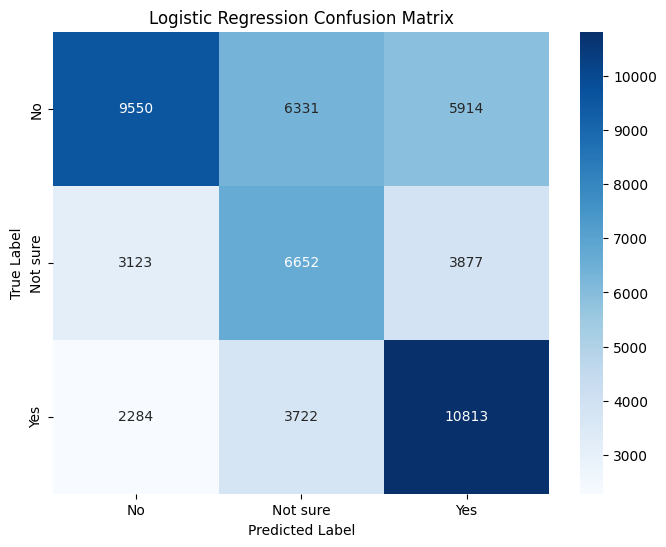

              precision    recall  f1-score   support

           0       0.64      0.44      0.52     21795
           1       0.40      0.49      0.44     13652
           2       0.52      0.64      0.58     16819

    accuracy                           0.52     52266
   macro avg       0.52      0.52      0.51     52266
weighted avg       0.54      0.52      0.52     52266



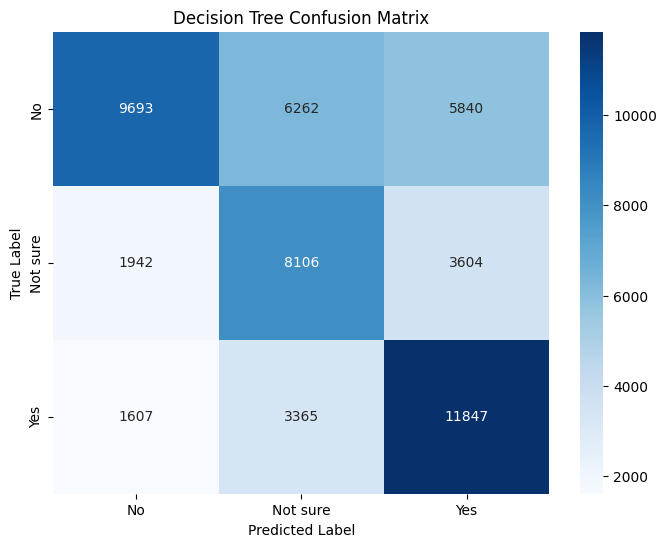

              precision    recall  f1-score   support

           0       0.73      0.44      0.55     21795
           1       0.46      0.59      0.52     13652
           2       0.56      0.70      0.62     16819

    accuracy                           0.57     52266
   macro avg       0.58      0.58      0.56     52266
weighted avg       0.60      0.57      0.57     52266



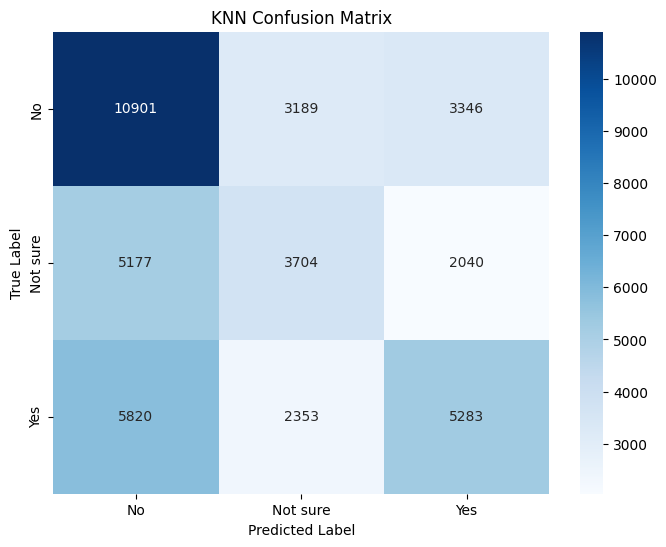

              precision    recall  f1-score   support

           0       0.50      0.63      0.55     17436
           1       0.40      0.34      0.37     10921
           2       0.50      0.39      0.44     13456

    accuracy                           0.48     41813
   macro avg       0.46      0.45      0.45     41813
weighted avg       0.47      0.48      0.47     41813



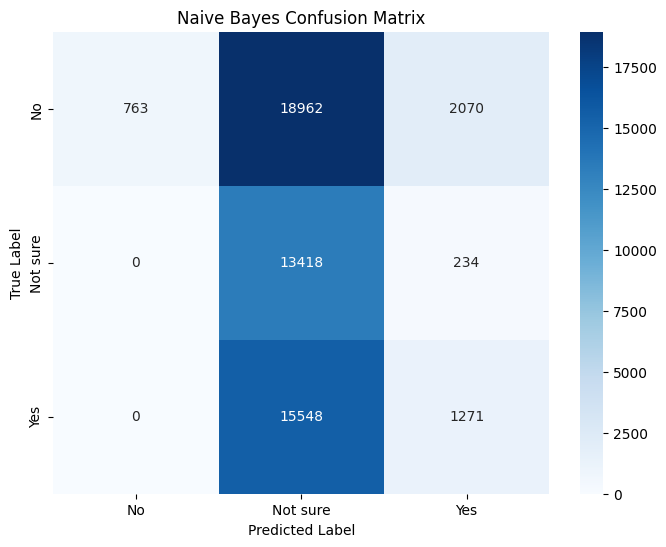

              precision    recall  f1-score   support

           0       1.00      0.04      0.07     21795
           1       0.28      0.98      0.44     13652
           2       0.36      0.08      0.12     16819

    accuracy                           0.30     52266
   macro avg       0.55      0.36      0.21     52266
weighted avg       0.60      0.30      0.18     52266



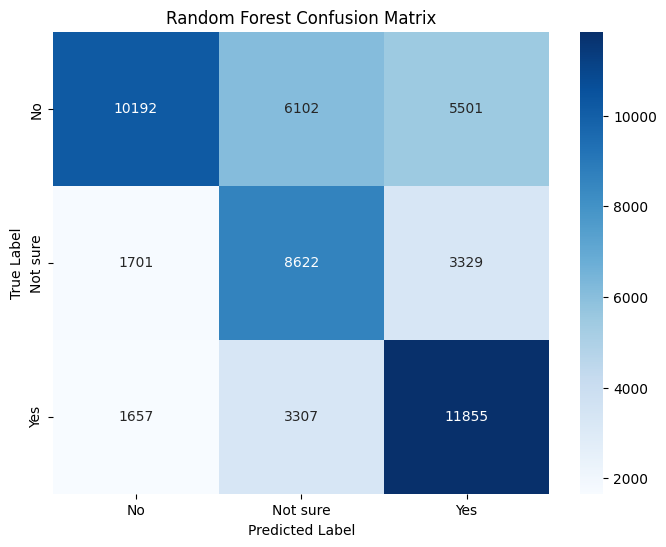

              precision    recall  f1-score   support

           0       0.75      0.47      0.58     21795
           1       0.48      0.63      0.54     13652
           2       0.57      0.70      0.63     16819

    accuracy                           0.59     52266
   macro avg       0.60      0.60      0.58     52266
weighted avg       0.62      0.59      0.59     52266



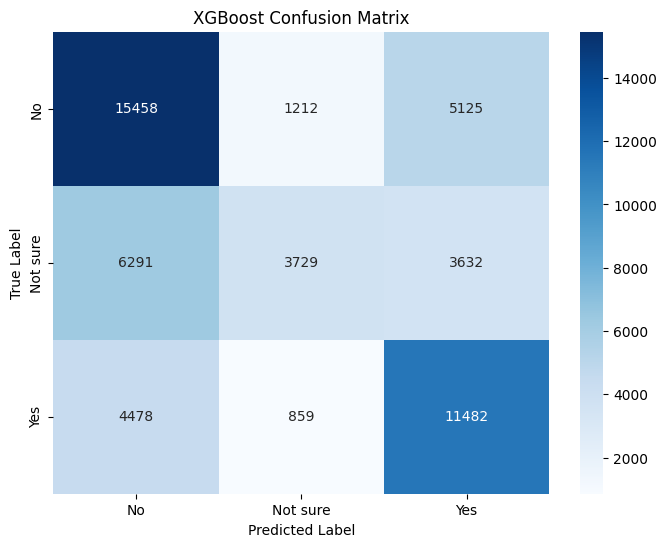

              precision    recall  f1-score   support

           0       0.59      0.71      0.64     21795
           1       0.64      0.27      0.38     13652
           2       0.57      0.68      0.62     16819

    accuracy                           0.59     52266
   macro avg       0.60      0.56      0.55     52266
weighted avg       0.60      0.59      0.57     52266



['label_encoder.pkl']

In [11]:
results = []

for name, model in models.items():
  if name == "KNN":
    pipeline = Pipeline([
      ("preprocessor", preprocessed_data),
      ("scaler", StandardScaler()),
      ("pca", PCA(n_components=8)),
      ("model", model)
    ])
    pipeline.fit(X_train_knn, y_train_knn)
    y_pred = pipeline.predict(X_test_knn)

    if len(np.unique(y_encoded)) == 2:
        y_prob = pipeline.predict_proba(X_test_knn)[:,1]
        auc = roc_auc_score(y_test_knn, y_prob)
    else:
        y_prob = pipeline.predict_proba(X_test_knn)
        auc = roc_auc_score(y_test_knn, y_prob, multi_class="ovr")

    accuracy = accuracy_score(y_test_knn, y_pred)
    precision = precision_score(y_test_knn, y_pred, average="macro")
    recall = recall_score(y_test_knn, y_pred, average="macro")
    f1 = f1_score(y_test_knn, y_pred, average="macro")
    matcorcoeff = matthews_corrcoef(y_test_knn, y_pred)

    results.append([name, accuracy, auc, precision, recall, f1, matcorcoeff])

    cm = confusion_matrix(y_test_knn, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(name + " Confusion Matrix")
    plt.show()

    print(classification_report(y_test_knn, y_pred))
  else:
    pipeline = Pipeline([
        ("preprocessor", preprocessed_data),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    if len(np.unique(y_encoded)) == 2:
        y_prob = pipeline.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = pipeline.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_prob, multi_class="ovr")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    matcorcoeff = matthews_corrcoef(y_test, y_pred)

    results.append([name, accuracy, auc, precision, recall, f1, matcorcoeff])

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(name + " Confusion Matrix")
    plt.show()

    print(classification_report(y_test, y_pred))

  joblib.dump(pipeline, f"{name}.pkl")

joblib.dump(label_encoder, "label_encoder.pkl")

In [12]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "AUC", "Precision", "Recall", "F1", "MCC"])
print(results_df)

                 Model  Accuracy       AUC  Precision    Recall        F1  \
0  Logistic Regression  0.516875  0.701390   0.520501  0.522777  0.511944   
1        Decision Tree  0.567214  0.756133   0.581845  0.580959  0.563860   
2                  KNN  0.475642  0.645895   0.464529  0.452326  0.453193   
3          Naive Bayes  0.295642  0.654250   0.545162  0.364479  0.209361   
4        Random Forest  0.586787  0.768916   0.601158  0.601348  0.584394   
5              XGBoost  0.586787  0.772402   0.599881  0.555024  0.548957   

        MCC  
0  0.284746  
1  0.369502  
2  0.185539  
3  0.088208  
4  0.398350  
5  0.361668  
